In [1]:
import os
if os.getcwd().endswith('notebooks'):
    os.chdir('..')

In [2]:
from notebooks.models import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Power-law

after talking with Elad, I think the solution we arrived at is:

For the unlabeled system, we have the age distribution:

$$ p_A(t) = \frac{1}{E_1(\frac{a}{\tau})} \frac{e^{-(a+t)/\tau}}{a+t} $$

the CDF of the age distribution is:
$$ P_A(t) = \int_0^t p_A(t') dt' = 1 - \frac{E_1(\frac{a + t}{\tau})}{E_1(\frac{a}{\tau})} $$

If we stop the inputs to the system at time $t'$, then the amount of carbon in the system is:
$$ C_{unlabeled}(t') = \int_{t'}^{\infty} p_A(t'') dt'' = 1 - P_A(t') = \frac{E_1(\frac{a + t'}{\tau})}{E_1(\frac{a}{\tau})} $$

and the amount of carbon in the labeled system at time $t'$ is:

$$ C_{labeled}(t') = \int_{0}^{t'} p_A(t'') dt'' = P_A(t') = 1 - \frac{E_1(\frac{a + t'}{\tau})}{E_1(\frac{a}{\tau})} $$

Assuming we had inputs $J_1$ for the unlabeled system and $J_2$ for the labeled system, then fraction of labeled carbon in the system at time $t'$ is:

$$ f(t') = \frac{J_2 \times C_{labeled}(t')}{J_1 \times C_{unlabeled}(t') + J_2 \times C_{labeled}(t')} = \frac{J_2 \times \left(1 - \frac{E_1(\frac{a + t'}{\tau})}{E_1(\frac{a}{\tau})}\right)}{J_1 \times \frac{E_1(\frac{a + t'}{\tau})}{E_1(\frac{a}{\tau})} + J_2 \times \left(1 - \frac{E_1(\frac{a + t'}{\tau})}{E_1(\frac{a}{\tau})}\right)}$$


I think, but not sure, that this is equivalent to the convolution of the impulse response $s(t)$ with the input $J(t)$, where:

$$ G(t) = \int_{0}^{t} J(t') s(t-t') dt' $$
$$ s(t) = \frac{a e^{-t/\tau}}{a+t} $$
$$ J_1(t) = J_1\ for\ t < t';\ 0\ for\ t \geq t' $$
$$ J_2(t) = 0\ for\ t < t';\ J_2\ for\ t \geq t' $$



I think a correction is needed: 

For the unlabeled system, we have the amount of carbon that is of a specific age $J * p_A(t) * T$ - so that the integral of all of the carbon in the system is $J * T$:

$$ J*p_A(t)*T = J\frac{1}{E_1(\frac{a}{\tau})} \frac{e^{-(a+t)/\tau}}{a+t} ae^{a/\tau}E_1(a/\tau) = J \frac{ae^{-t/\tau}}{a+t} = Js(t)$$

where T is:
$$ T = ae^{a/\tau}E_1(a/\tau) $$

When at time $t'$, we stop the inputs to the system, the amount of carbon in the unlabeled system is all of the carbon that is older than $t'$:

$$ C_{unlabeled}(t') = \int_{t'}^{\infty} Js(t'') dt'' = 
J\int_{t'}^{\infty} \frac{ae^{-t''/\tau}}{a+t''} dt'' = 
J \left.-ae^{a/\tau} E_1(\frac{a + t'}{\tau})\right|^{\infty}_{t'}  = J ae^{a/\tau} E_1(\frac{a + t'}{\tau})$$

and the amount of carbon in the labeled system at time $t'$ is the same, but only for tages 0 to $t'$:

$$ C_{labeled}(t') = \int_{0}^{t'} Js(t'') dt'' = 
J\int_{0}^{t'} \frac{ae^{-t''/\tau}}{a+t''} dt'' = 
J \left.-ae^{a/\tau} E_1(\frac{a + t'}{\tau})\right|^{0}_{t'}  = J ae^{a/\tau}[E_1(\frac{a}{\tau}) - E_1(\frac{a + t'}{\tau})]$$

Assuming we had inputs $J_1$ and parameters $a_1$ and $\tau_1$ for the unlabeled system and $J_2$ and parameters $a_2$ and $\tau_2$ for the labeled system, then fraction of labeled carbon in the system at time $t'$ is:

$$ f(t') = \frac{J_2 \times C_{labeled}(t')}{J_1 \times C_{unlabeled}(t') + J_2 \times C_{labeled}(t')} = \frac{J_2 a_2e^{a_2/\tau_2} E_1(\frac{a_2 + t'}{\tau_2})}{J_1 a_1e^{a_1/\tau_1}[E_1(\frac{a_1}{\tau_1}) - E_1(\frac{a_1 + t'}{\tau_1})] + J_2 a_2e^{a_2/\tau_2} E_1(\frac{a_2 + t'}{\tau_2})}$$

In [76]:
# old formulation
tropical_sites = pd.read_csv('results/tropical_sites_14C_turnover.csv')
i =3
powerlaw_params = pd.read_csv('results/powerlaw_model_optimization_results.csv')
row = powerlaw_params.iloc[i]
powerlaw_model = PowerLawDisKin(tau_0=row['tau_0'], tau_inf=row['tau_inf'])

cdf  = lambda t:  (1 - exp1((powerlaw_model.t0 + t) / powerlaw_model.tinf) / exp1(powerlaw_model.tratio) )

J1 = 1
J2 = 1.7
f_new_old = lambda t, J1, J2: J2 * cdf(t) / (J2 * cdf(t) + J1 * (1 - cdf(t)))

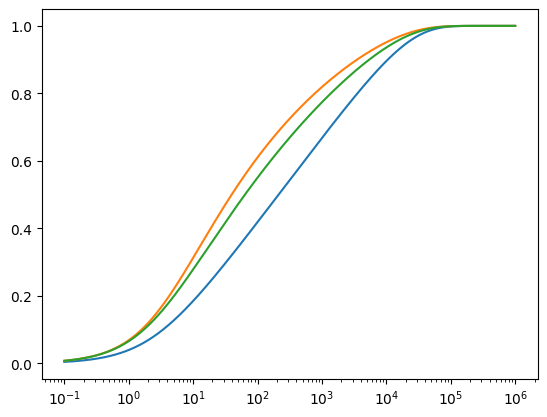

In [77]:
# old formulation
tropical_sites = pd.read_csv('results/tropical_sites_14C_turnover.csv')
i =3
powerlaw_params = pd.read_csv('results/powerlaw_model_optimization_results.csv')
row = powerlaw_params.iloc[i]
powerlaw_model = PowerLawDisKin(tau_0=row['tau_0'], tau_inf=row['tau_inf'])

int_s_labeled  = lambda t, a, tau:  a * np.exp(a / tau) * (exp1(a / tau) - exp1((a + t) / tau)  )
int_s_unlabeled = lambda t, a, tau: a * np.exp(a / tau) *  exp1((a + t) / tau) 
J1 = 1
J2 = 1.7
f_new = lambda t, J1, J2, a1, a2, tau1, tau2: J2 * int_s_labeled(t, a2, tau2) / (J2 * int_s_labeled(t, a2, tau2) + J1 * int_s_unlabeled(t, a1, tau1))
a1 = powerlaw_model.t0
tau1 = powerlaw_model.tinf
a2 = a1 * 1.4
tau2 = tau1 * 1
ts = np.logspace(-1, 6, 1000)  # time in years
plt.semilogx(ts, cdf(ts))
plt.semilogx(ts, f_new(ts, J1, J2, a1, a2, tau1, tau2))
plt.semilogx(ts, f_new_old(ts, J1, J2))



In [78]:
site_data

,Latitude,Longitude,Duration_labeling,total_fnew,weight_0,weight_10,weight_20,weight_30,weight_40,weight_50,weight_60,weight_70,weight_80,weight_90,Ctotal_0-100estim
0,-22.720000,-47.630000,12.0,0.161798,0.252888,0.269576,0.136072,0.116816,0.097561,0.060334,0.066752,NaN,NaN,NaN,9.581006
1,-21.317900,55.504744,100.0,0.524255,0.164812,0.164812,0.147961,0.129669,0.111377,0.071998,0.061275,0.050552,0.048772,0.048772,14.883650
2,-21.301844,55.535514,65.0,0.265834,0.174784,0.120388,0.106751,0.105379,0.099891,0.095890,0.079884,0.077064,0.068585,0.071385,11.036000
3,-21.294758,55.566142,15.0,0.120593,0.131364,0.138230,0.127277,0.122658,0.119623,0.089560,0.070207,0.063757,0.068662,0.068662,29.361260
4,-20.905300,55.588939,100.0,0.393939,0.257370,0.171647,0.159588,0.087271,0.058034,0.073300,0.052307,0.050133,0.046827,0.043522,17.788346
5,-20.903503,55.588336,186.0,0.472015,0.145312,0.124729,0.118858,0.115655,0.120767,0.111775,0.069855,0.062501,0.064349,0.066197,16.920078
6,-19.433333,-44.166667,23.0,0.266480,0.146892,0.145667,0.126986,0.110629,0.099814,0.088794,0.086039,0.073451,0.060863,0.060863,19.274125
7,-19.300000,-40.316667,17.0,0.242118,0.139325,0.106442,0.120397,0.112325,0.096778,0.096778,0.091151,0.091151,0.072827,0.072827,10.044474
8,-19.083333,-48.116667,12.0,0.214094,0.170113,0.146325,0.122537,0.086660,0.086660,0.086660,0.086660,0.086660,0.063864,0.063864,18.314379
9,-19.083333,-48.116667,20.0,0.148997,0.158857,0.140423,0.121989,0.088262,0.088262,0.088262,0.088262,0.088262,0.068711,0.068711,16.662444


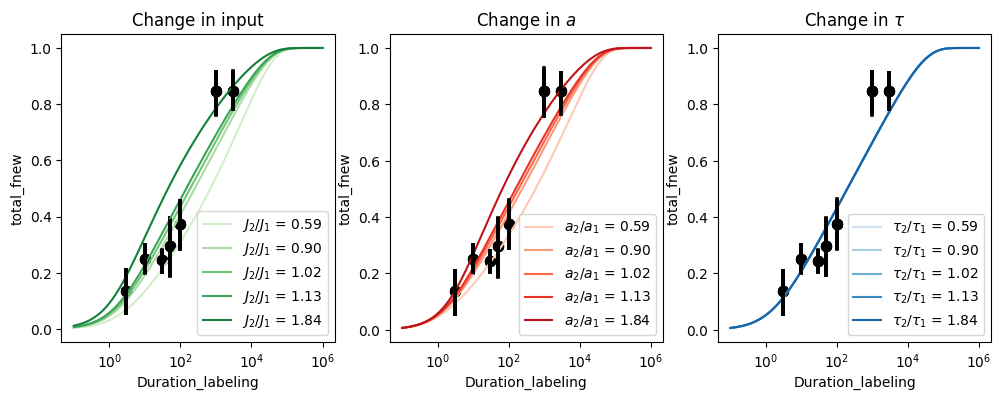

In [79]:
raw_site_data = pd.read_excel('data/balesdant_2018/41586_2018_328_MOESM3_ESM.xlsx', skiprows=7)
site_data = pd.read_csv('results/processed_balesdant_2018.csv')
J_ratio = raw_site_data['Cref_0-100estim'] / raw_site_data['Ctotal_0-100estim']

# tropical_sites = pd.read_csv('results/tropical_sites_14C_turnover.csv')
# i =3
# powerlaw_params = pd.read_csv('results/powerlaw_model_optimization_results.csv')
# row = powerlaw_params.iloc[i]
# powerlaw_model = PowerLawDisKin(tau_0=row['tau_0'], tau_inf=row['tau_inf'])
powerlaw_params = pd.read_csv('results/powerlaw_model_optimization_results.csv')

a1 = powerlaw_params['tau_0'].mean()
tau1 = powerlaw_params['tau_inf'].mean()


# np.percentile(J_ratio.dropna(),[0.025, 0.975])  # 0.025, 0.975 percentiles
ratios = np.percentile(J_ratio.dropna().values,[2.5, 25, 50, 75, 97.5])

fig, axs = plt.subplots(1, 3, figsize=(12, 4))



ts = np.logspace(-1, 6, 1000)  # time in years

green_colors = plt.cm.Greens(np.linspace(0.2, 0.8, 5))
red_colors = plt.cm.Reds(np.linspace(0.2, 0.8, 5))
blue_colors = plt.cm.Blues(np.linspace(0.2, 0.8, 5))

input_data = [f_new(ts, 1, 1 * j, a1, a1, tau1, tau1) for j in ratios]
a_data = [f_new(ts, 1, 1 , a1, a1 * j, tau1, tau1) for j in ratios]
tau_data = [f_new(ts, 1, 1 , a1, a1, tau1, tau1 * j) for j in ratios]

def plot_data(ax, ts, data, colors, title_label, legend_label):
    for j, d in enumerate(data):
        ax.semilogx(ts, d, color=colors[j], label=f'{legend_label} = {ratios[j]:.2f}')
        ax.set_xlabel('Time (years)')
        ax.set_ylabel('Fraction of labeled carbon')
        ax.legend(loc='lower right')
        sns.regplot(data=site_data, x="Duration_labeling", y="total_fnew",ax=ax,scatter_kws={'color':'k'},line_kws={'color':'k','lw':0},x_bins=[3,10,30,50,100,300,1000,3000],fit_reg=False,ci=95)
        ax.set_title(title_label)
    
plot_data(axs[0], ts, input_data, green_colors, 'Change in input', '$J_2$/$J_1$')
plot_data(axs[1], ts, a_data, red_colors, 'Change in $a$', '$a_2$/$a_1$')
plot_data(axs[2], ts, tau_data, blue_colors, 'Change in $\\tau$', '$\\tau_2$/$\\tau_1$')
